# Action-decision networks for visual tracking


## Imports
All the imports are defined here

In [ ]:
%matplotlib inline
import torchvision
from collections import namedtuple
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
from itertools import count
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import time
!pip install pytorch_metric_learning
from pytorch_metric_learning import miners, losses
import cv2
import re
import math
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

     |████████████████████████████████| 81kB 2.3MB/s 


ERROR:root:The testing module requires faiss. You can install the GPU version with the command 'conda install faiss-gpu -c pytorch' 
                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


Device: cuda


In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Helper functions
Set of helper functions

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


def bb_intersection_over_union(boxA, boxB, change_format = True):
    if change_format:
      boxA[2] += boxA[0]
      boxA[3] += boxA[1]
      boxB[2] += boxB[0]
      boxB[3] += boxB[1]
      
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [ ]:
action_amount = 11
pre_action_amount =10


In [ ]:
#Helper function

transform_tensor = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

def showActions(frame,bbs, true_bb = None):
  if true_bb is not None:
    frame = cv2.rectangle(frame, (true_bb[0], true_bb[1]), (true_bb[0]+true_bb[2], true_bb[1]+true_bb[3]), (0,255,0), 2)    

  for bb in bbs:
    frame = cv2.rectangle(frame, (bb[0], bb[1]), (bb[0]+bb[2], bb[1]+bb[3]), (255,0,0), 2)

 
  imshow(transform_tensor(frame))


### Configuration Class
A simple class to manage configuration

In [ ]:
class Config():
    local_dir = F"../"
    google_dir = F"/content/gdrive/My Drive/"
    dir = google_dir
    model_dir = dir + F"/DTU - Speciale F2020/Action_Decision_Network/Models/"
    training_dir = dir +F"/DTU - Speciale F2020/Action_Decision_Network/Data/Training/"
    validation_dir = dir + F"DTU - Speciale F2020/Action_Decision_Network/Data/Validation/"
    testing_dir = dir + F"DTU - Speciale F2020/Action_Decision_Network/Data/Test"
    train_batch_size = 64
    test_batch_size = 1
    train_number_epochs = 100
    label_names = tuple(("Left", "Right", "Up", "Down", "Double left", "Double right", "Double up", "Double down", "Scale down", "Scale up", "Stop"))

In [ ]:
transform = transforms.Compose([#transforms.RandomHorizontalFlip(p=0.5),
                                #transforms.RandomAffine((0,0), translate=(0.1,0.1), scale =  (1, 1.2)),
                                #transforms.ColorJitter((0.5,2)),
                                #transforms.Resize((275,134)),
                                #transforms.RandomChoice([transforms.RandomCrop((200,100))
                                transforms.ToPILImage(),
                                transforms.Resize((100,50)),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                #transforms.RandomErasing(scale=(0.02, 0.2)),
                                ])


#siamese_dataset_test = ADNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                        transform=transforms.Compose([transforms.Resize((200,100)),
#                                                                      transforms.ToTensor()
#                                                                      ])
#                                       ,should_invert=False)

### Neural Net Definition
We will use a standard convolutional neural network

In [ ]:
class ADNet(nn.Module):
    def __init__(self, m, k):
        super(ADNet, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(0.05),

            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.05),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.05),

            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.05),

            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.05),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8 * 50 * 25, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512+m*k, m+2)
        )

        self.softmax = nn.Softmax(-1)
        self.m = m

    def forward(self, x, pre_actions):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        output = torch.cat((output,pre_actions),1)
        output = self.fc2(output)
        
        action = self.softmax(output[:,0:self.m])
        confidence = self.softmax(output[:,self.m:])

        return action, confidence

class ADDuelingNet(nn.Module):
    def __init__(self, m, k):
        super(ADDuelingNet, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),


            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )



        self.fc_v = nn.Sequential(
            nn.Linear(8 * 50 * 25 +m*k, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )      


        self.fc_a = nn.Sequential(
            nn.Linear(8 * 50 * 25 +m*k, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, m)
        )

        self.softmax = nn.Softmax(-1)
        self.m = m

    def forward(self, x, pre_actions):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = torch.cat((output,pre_actions),1)
        v = self.fc_v(output)
        a = self.fc_a(output)
        q = v[:,0:1] + a - a.mean()


        return self.softmax(q), self.softmax(v)

### Enviroment



In [ ]:
class ADenviroment:
    # init method or constructor   
    def __init__(self, dir = None, transform = None, max_notfound = None):
        self.transform = transform  
        self.state = []
        self.count = 0
        self.reward_count = 0
        self.pre_IoU = 0
        self.files  = []
        self.start_frame_number = 0
        self.frame_number = 0
        self.lines  = []
        self.true_bb  = []
        self.bb = []
        self.frame  = []
        self.pre_frame = []
        self.last_frame = False
        self.done = False
        self.reset(dir)

        if max_notfound is None:
          self.max_notfound = 100
        else:
          self.max_notfound = max_notfound*2

    def getState(self):
        return self.state, 0, self.done #state, reward, done status

    def step(self, action):
      new_frame = False
      height = self.bb[3]*0.03
      width = self.bb[2]*0.03
      width = width if width >= 1 else 1
      height = height if height >= 1 else 1
      #actions = np.array(([-width, 0, 0, 0],    #left
      #                    [width, 0, 0, 0],   #right
      #                    [0, -height, 0, 0],   #Up
      #                    [0, height, 0, 0],  #Down
      #                    [-width*3, 0, 0, 0],  #Double Left
      #                    [width*3, 0, 0, 0], #Double Right
      #                    [0, -height*3, 0, 0], #Double up
      #                    [0, height*3, 0, 0],#Double down
      #                    [width/2, height/2,-width, -height], #Scale down # Need to get fixed
      #                    [-width/2, -height/2, width, height,], #Scale up # Need to get fixed
      #                    [0, 0, 0, 0]),dtype=np.int) #None

      actions = np.array(([-width, 0, width, 0],    #left
                          [-width*3, 0, width*3, 0],    #left
                          [width, 0, -width, 0],   #right
                          [width*3, 0, -width*3, 0],   #right
                          [0, 0, width, 0],    #left
                          [0, 0, width*3, 0],    #left
                          [0, 0, -width, 0],   #right
                          [0, 0, -width*3, 0],   #right
                          [0, -height, 0, height],   #Up
                          [0, -height*3, 0, height*3],   #Up
                          [0, height, 0, -height],   #Up
                          [0, height*3, 0, -height*3],   #Up
                          [0,0, 0, height],   #Up
                          [0, 0, 0, height*3],   #Up
                          [0, 0, 0, -height],   #Up
                          [0, 0, 0, -height*3],   #Up
                          [0, 0, 0, 0]),dtype=np.int) #None

      self.bb += actions[action]
      self.bb[self.bb< 1] = 1
      if self.bb[1]+self.bb[3] > self.frame.shape[0]:
        self.bb[1] = self.frame.shape[0]-self.bb[3]
      if self.bb[0]+self.bb[2] > self.frame.shape[1]:
        self.bb[0] = self.frame.shape[1]-self.bb[2]

      self.state = self.frame[self.bb[1]:self.bb[1]+self.bb[3],self.bb[0]:self.bb[0]+self.bb[2],:]

      IoU = bb_intersection_over_union(self.true_bb.copy(),self.bb.copy())

      if IoU > 0.7 and action == 16:
        reward = 1
        if not self.last_frame:
          self.count = 0
          self.frame_number += 3
          line = re.split(r'[;,\s]\s*',self.lines[self.frame_number])
          if len(line) > 4:
            line = line[0:-1]
          self.true_bb = np.array(line,dtype=np.int)
          self.pre_frame = self.frame.copy()
          self.frame = cv2.imread(self.dir+self.files[self.frame_number])
          self.last_frame = len(self.lines) <= self.frame_number+3
          new_frame = True
        else:
          self.state = None
          self.done = True
      elif self.count >= self.max_notfound or IoU < 0.35 or action == 16:
        reward = -1
        self.count = 0
        if self.last_frame:
          self.state = None

        self.done = True
      else:
        self.count -= 1
        reward = 0

      #print("IoU:", IoU, "\tCount:", self.count, "\tDone:", self.done)
      #self.frame = cv2.imread(dir+self.files[self.frame_number])
      # Guided reward
      reward += (IoU - self.pre_IoU)*0.1


      if new_frame:
        self.pre_IoU = bb_intersection_over_union(self.true_bb.copy(),self.bb.copy())
      else:
        self.pre_IoU = IoU

      if self.transform is not None and self.state is not None:
        self.state = self.transform(self.state).unsqueeze(0)

      return self.state, float(reward), new_frame, self.done

    def getRealBB(self):
      return self.true_bb

    def reset(self, directory = None):
      while True:
        try:
          if directory == None:
            dirs = os.listdir(Config.training_dir)
            self.dir = Config.training_dir + dirs[random.randint(0,len(dirs)-1)] +"/"
          else:
            self.dir = Config.training_dir + directory



          #print("New directory:", self.dir)
          self.files = os.listdir(self.dir)
          self.files.sort()
          self.start_frame_number = random.randint(1, int(len(self.files)*0.9)-1)
          self.frame_number = self.start_frame_number
          file = open(self.dir + '/groundtruth_rect.txt')
          break
        except:
          pass

      self.lines = file.readlines()
      line = re.split(r'[;,\s]\s*',self.lines[self.frame_number-1])
      if len(line) > 4:
        line = line[0:-1]
      self.bb = np.array(line,dtype=np.int)

      line = re.split(r'[;,\s]\s*',self.lines[self.frame_number])
      if len(line) > 4:
        line = line[0:-1]
      self.true_bb = np.array(line,dtype=np.int)
      
      self.frame = cv2.imread(self.dir+self.files[self.frame_number])

      if self.frame.shape[2] == 1:
        self.frame = cv2.merge((self.frame,self.frame,self.frame))


      while bb_intersection_over_union(self.bb.copy(),self.true_bb.copy()) > 0.6:
        self.bb[0] += self.bb[2]*random.uniform(-0.1,0.1)
        self.bb[1] += self.bb[3]*random.uniform(-0.1,0.1)
        self.bb[self.bb< 1] = 1
        if self.bb[1]+self.bb[3] > self.frame.shape[0]:
          self.bb[1] = self.frame.shape[0]-self.bb[3]
        if self.bb[0]+self.bb[2] > self.frame.shape[1]:
          self.bb[0] = self.frame.shape[1]-self.bb[2]


      self.pre_frame = self.frame.copy()
      self.state = self.frame[self.bb[1]:self.bb[1]+self.bb[3],self.bb[0]:self.bb[0]+self.bb[2],:]

      if self.transform is not None:
        self.state = self.transform(self.state).unsqueeze(0)
      
      if len(self.files) > 2:
        self.last_frame = False
      else:
        self.last_frame = True

      self.done = False
      self.count = 0



/content/gdrive/My Drive//DTU - Speciale F2020/Action_Decision_Network/Data/Training/Girl2/
['424', '133', '45', '174']
1202 1501 20
/content/gdrive/My Drive//DTU - Speciale F2020/Action_Decision_Network/Data/Training/Human2/
['279', '255', '79', '232']


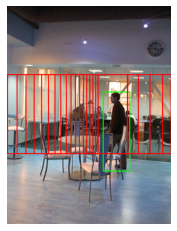

In [ ]:
# Enviroment test
env = ADenviroment(None, transform, pre_action_amount)
print(env.frame_number, len(env.files), env.max_notfound)
#net.eval()
state, reward, done = env.getState()
bb = [env.bb.copy()]
pre_action = [0]*action_amount *pre_action_amount
pre_action = [float(i) for i in pre_action]
pre_action = torch.tensor([pre_action], requires_grad=True).cuda()

env.reset("Human2/")

bb = []

for _ in range(100):
  #action = random.randint(0,1)
  #action, confidence = policy_net(state.cuda(), pre_action.cuda())
  #print("Action:", Config.label_names[action.max(1)[1].view(1,1).item()],action.max(1)[1].view(1,1).item(), "\tConfidence:", confidence[0,0].item())
  state, reward, new_frame, done = env.step(1)#action.max(1)[1].view(1,1))
  bb.append(env.bb.copy())
  draw = True
  if new_frame and draw:
    print(env.getRealBB())
    showActions(env.pre_frame.copy(),bb, env.getRealBB().copy())
    bb = []
    draw = False
  if state is None:
    break


#Draw fianl
if draw:
  showActions(env.pre_frame.copy(),bb, env.getRealBB().copy())
  bb = []
  draw = False

### Replay memory

In [ ]:
Transition = namedtuple('Transition',('state', 'action', 'pre_action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(Transition(*args))
        else:
          del self.memory[self.position] 
          self.memory.insert(self.position, Transition(*args))
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

def sample_memory(memory, device, non_blocking=False):
    # sample replay buffer
    transitions = memory.sample(BATCH_SIZE)
    try:
      batch = Transition(*zip(*transitions))
    except:
      print("Object not iterable")
      return None

    # convert to tensors and create batches
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    non_final_pre_actions = torch.cat([pa for s, pa in zip(batch.next_state, batch.pre_action) if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    pre_action_batch = torch.cat(batch.pre_action)
    reward_batch = torch.cat(batch.reward)



    return state_batch, action_batch, pre_action_batch, reward_batch, non_final_mask, non_final_next_states, non_final_pre_actions

In [ ]:
# SumTree - https://github.com/rlcode/per/blob/master/SumTree.py
# a binary tree data structure where the parent’s value is the sum of its children
# Needed for the Prioritized Experience Replay
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [ ]:
#Prioritized Experience Replay - https://sergioskar.github.io/Taking_Deep_Q_Networks_a_step_further/
class PER:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6
    def __init__(self, capacity, discount_factor,  non_blocking=False):
        self.tree = SumTree(capacity)
        self.discount_factor = discount_factor
        self.non_blocking = non_blocking

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, *args):
        p = self._getPriority(error)
        self.tree.add(p, Transition(*args))

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append(data)

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

    def push(self, state, action, pre_action, reward, next_state, done, model, target_model):

        action_encoded = torch.tensor(np.zeros((n_actions), dtype = np.int)).unsqueeze(0).float()

        target, _ = model(state.cuda(), pre_action.cuda())
        old_val = target[0][action]
        
        if done:
            target[0][action] = reward
        else:
            next_pre_action = torch.cat((action_encoded, pre_action[:,:-17].float()), 1)
            next_pre_action[:,action[0,0]] = 1
            target_val, _ = model(next_state.cuda(), next_pre_action.cuda())
            target[0][action[0,0]] = reward + self.discount_factor * torch.max(target_val)

        error = abs(old_val - target[0][action])
        self.add(error, state.cpu(), action.cpu(), pre_action.cpu(), next_state.cpu(), reward)


## Reinforcement Training Time!





In [ ]:
# Trainin parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.15
EPS_END = 0.01
MEMORY_SIZE = 100000
EPS_DECAY = 50000
TARGET_UPDATE = 2000
START_OPTIMIZER = 512
OPTIMIZE_FREQUENCE = 4
learning_rate = 10e-6
action_amount = 17
pre_action_amount = 10
#net = ADNet(action_amount,pre_action_amount).cuda()

n_actions = 17 #env.action_space.n  # 3 redundant actions - Usefull actiosn 

# Initializes networks
#policy_net = DQN(4, n_actions).to(device)
#target_net = DQN(4, n_actions).to(device)
#policy_net = DuelingDQN(4, n_actions).to(device)
#target_net = DuelingDQN(4, n_actions).to(device)
action_amount = 17
pre_action_amount =10
#policy_net = torch.load(Config.model_dir+"ADNet_RL_Mar_12_2020_1722.pt").cuda()
policy_net = ADNet(action_amount,pre_action_amount).cuda()
policy_net.load_state_dict(torch.load(Config.model_dir+"ADNet_SL_Advanced_Mar_30_2020_1156.pt"))
target_net = ADNet(action_amount,pre_action_amount).cuda()
target_net.load_state_dict(policy_net.state_dict())
policy_net.train()
target_net.eval()
env = ADenviroment(None, transform, pre_action_amount)
print("Enviroment start frame:", env.start_frame_number, " - Total frame:", len(env.files), " - Enviroment max not found:", env.max_notfound)

optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate)
#optimizer = optim.SGD(policy_net.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate)

memory = ReplayMemory(MEMORY_SIZE)
#memory = PER(MEMORY_SIZE, GAMMA)

timestamp = time.strftime('%b_%d_%Y_%H%M', time.localtime())
if not 'BACKUP_NAME' in locals():
  BACKUP_NAME = "ADNet_RL_" + timestamp + ".pt"
path = Config.model_dir + BACKUP_NAME
#torch.save(policy_net.state_dict(), path)
print(path)

steps_done = 0
i_episode = 0
num_episodes = 100000
loss = list()
state_cuda = []
episode_durations = []
episode_totalRewards = []


def select_action(state, pre_actions, policy):
    global steps_done
    sample = random.random()

    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)

      
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            action, confidence = policy(state, pre_actions)
            return action.max(1)[1].view(1,1), eps_threshold, 
    else:
        if random.uniform(0,1) > 0.75:
          action = 10
        else:
          action = random.randrange(n_actions-1)
        return torch.tensor([[action]], device=device, dtype=torch.long), eps_threshold

Enviroment start frame: 249  - Total frame: 309  - Enviroment max not found: 20
/content/gdrive/My Drive//DTU - Speciale F2020/Action_Decision_Network/Models/ADNet_RL_May_17_2020_1333.pt


**Define optimize function**

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability.**bold text**


In [ ]:
def optimize_model(policy_net, target_net, memory, batch=None):
    #Prepare networks
    policy_net.train()
    target_net.eval()

    #if len(memory) < BATCH_SIZE:
    #    return

    if batch is None:
        batch = sample_memory(memory, device)

    if batch is None:
      return

    state_batch, action_batch, pre_actions_batch, reward_batch, non_final_mask, non_final_next_states, non_final_pre_actions = batch
    state_batch, action_batch, pre_actions_batch, reward_batch, non_final_mask, non_final_next_states, non_final_pre_actions = state_batch.to(device), action_batch.to(device), pre_actions_batch.to(device), reward_batch.to(device), non_final_mask.to(device), non_final_next_states.to(device), non_final_pre_actions.to(device)

    state_action_values, state_confidence_values = policy_net(state_batch, pre_actions_batch)
    state_action_values = state_action_values.gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # Compute expected state action value
    argmax_next_state_values, _ = policy_net(non_final_next_states, non_final_pre_actions)
    argmax_next_state_values = argmax_next_state_values.argmax(1).detach().unsqueeze(1)
    temp, _ = target_net(non_final_next_states, non_final_pre_actions)
    next_state_values[non_final_mask] = temp.gather(1,argmax_next_state_values).detach().squeeze()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch


    # compute loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # optimize
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 10.)
    optimizer.step()
    del state_batch
    del action_batch
    del pre_actions_batch
    del reward_batch
    del non_final_mask
    del state_action_values
    del state_confidence_values
    del non_final_next_states
    del non_final_pre_actions
    del argmax_next_state_values
    del temp
    del next_state_values
    del expected_state_action_values
    del loss
    torch.cuda.empty_cache()


In [ ]:
def test_network(env, n_episodes, policy):
    episode_test_totalRewards =[]
    episode_test_durations = []
    for episode in range(n_episodes):
      env.reset()
      pre_action = [0]*action_amount *pre_action_amount
      pre_action = [float(i) for i in pre_action]
      pre_action = torch.tensor([pre_action], requires_grad=True).cuda()
      state, reward, done = env.getState()
      total_reward = 0.0
      for t in count():
          state_cuda = state.to(device)
          action, confidence = policy_net(state_cuda, pre_action)
          action = action.max(1)[1].view(1,1)
          pre_action = torch.cat((action.float(), pre_action[:,:-1].float()), 1)
          state, reward, new_frame, done = env.step(action.item())
          total_reward += reward
          
          if done or t > 12000:
              episode_test_durations.append(t + 1)
              episode_test_totalRewards.append(total_reward)
              break
          del state_cuda
          del action
          del confidence
    mean = np.mean(episode_test_totalRewards)
    var = np.var(episode_test_totalRewards)
    del pre_action
    torch.cuda.empty_cache()
    return mean, var

env_test = ADenviroment(None,  transform)
mean, var = test_network(env_test, 20, policy_net)
print("Mean:", mean, " - Variance:", var)

Mean: -0.8957679134400118  - Variance: 0.09114780248697033


**Run training**

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward, and optimize our model once. When the episode ends, we restart the loop.




In [ ]:
Test = False
policy_net.eval()
target_net.eval()
num_episodes = 1000000
max_reward = 0

action_encoded = torch.tensor(np.zeros((n_actions), dtype = np.int)).unsqueeze(0).float()

if Test:
  test_episode_totalReards_mean = []
  test_episode_totalReards_var = []

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()#"Human2/")
    pre_action = [16]*action_amount *pre_action_amount
    pre_action = [float(i) for i in pre_action]
    pre_action = torch.tensor([pre_action], requires_grad=True)

    state, reward, done = env.getState()
    total_reward = 0.0
    next_state = state.clone()
    actions = np.zeros((n_actions), dtype = np.int)
    new_frame_count = 0

    for t in count():
        # Select and perform an action
        pre_action_cuda, state_cuda = pre_action.cuda(), state.cuda()
        action, threshold = select_action(state_cuda, pre_action_cuda, policy_net)
        pre_action = torch.cat((action_encoded, pre_action[:,:-n_actions].float()), 1)
        pre_action[:,action] = 1
        next_state, reward, new_frame, done = env.step(action)
        new_frame_count += int(new_frame)
        total_reward += reward
        actions[action] += 1
        reward = torch.tensor([reward])
        # Store the transition in memory
        memory.push(state, action.cpu(), pre_action.cpu(), next_state, reward)
        #memory.push(state, action.cpu(), pre_action.cpu(), reward,  next_state, done, policy_net, target_net)
        # Move to the next state
        if next_state is not None:
            state = next_state
        else:
            state = None
        

        # Perform one step of the optimization (on the target network)
        if (steps_done % OPTIMIZE_FREQUENCE == 0) and steps_done > START_OPTIMIZER:
            optimize_model(policy_net, target_net, memory)      
        if done:
            episode_durations.append(new_frame_count)
            episode_totalRewards.append(total_reward)
            break

        # Update the target network
        if steps_done % TARGET_UPDATE == 0 and steps_done > (START_OPTIMIZER +TARGET_UPDATE):
            target_net.load_state_dict(policy_net.state_dict())
            
        torch.cuda.empty_cache()
    # Print status parameters
    print("Episode number:", i_episode, " - Total reward:", round(total_reward,2), " - Episode duration: ", episode_durations[-1], "\t  - Frames:", new_frame_count, " - Threshold: %.2f" % threshold, " - Actions: ", actions, "- Steps:", steps_done)
    # Save model
    reward_mean = np.array(episode_totalRewards).mean() if len(episode_totalRewards)< 100 else np.array(episode_totalRewards[-100:]).mean()  
    if i_episode % 100 == 0 and threshold < 0.2 and reward_mean > max_reward:
      torch.save(policy_net.state_dict(), path)
      print("Model Saved %d" %(i_episode))

    if Test and i_episode % 10 == 0:
      mean, var = test_network('PongDeterministic-v4', 10, policy_net)
      test_episode_totalReards_mean.append(mean)
      test_episode_totalReards_var.append(var)
      print("Mean:", mean, " - Variance:", var)


    if i_episode % 1000 == 0:
      # Plot learning curves
      plt.figure()
      plt.clf()
      durations_t = torch.tensor(episode_durations, dtype=torch.float)
      plt.title('Training...')
      plt.xlabel('Episode')
      plt.ylabel('Duration')
      plt.plot(durations_t.numpy())
      # Take 100 episode averages and plot them too
      if len(durations_t) >= 50:
          means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
          means = torch.cat((torch.zeros(9), means))
          plt.plot(means.numpy())
    
      plt.figure()
      rewards_t = torch.tensor(episode_totalRewards, dtype=torch.float)
      plt.title('Training...')
      plt.xlabel('Step')
      plt.ylabel('Reward')
      plt.plot(rewards_t.numpy())
      if len(durations_t) >= 50:
        means = rewards_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy())
        plt.show()
    
    # Clear used cuda memory
    torch.cuda.empty_cache()


print('Complete')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

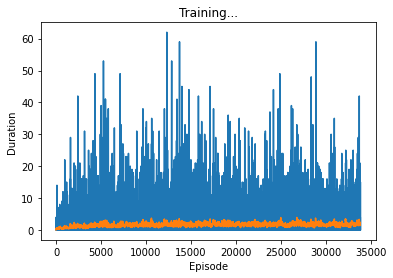

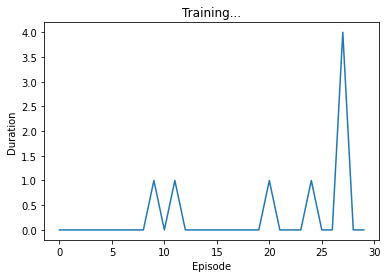

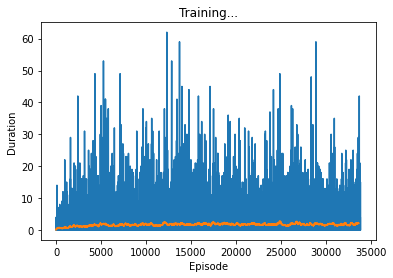

In [ ]:
# Plot learning curves
plt.figure(2)
plt.clf()
durations_t = torch.tensor(episode_durations, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())

plt.figure(3)
plt.clf()
durations_t = torch.tensor(episode_durations, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 2, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())

plt.figure(4)
plt.clf()
durations_t = torch.tensor(episode_durations, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 200, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())




**Save model**

Testing
--------
This sections is used to test the DQN and show the resulting mp4 video. 

First we define our test fuction.

In [ ]:
# Set up test enviroment functions
def find_files(root, extension):
    for file in os.listdir(root):
        if file.endswith(extension):
          return file

    return None

def test(env, n_episodes, policy, path = F"/videos", render=True):
    env = gym.wrappers.Monitor(env, path, force=True)
    state = torch.cat((get_screen(env),get_screen(env),get_screen(env),get_screen(env)), dim=1, out=None)
    next_state= state.clone()
    for episode in range(n_episodes):
        obs = env.reset()
        total_reward = 0.0
        for t in count():
            state_cuda = state.to(device)
            action = policy(state_cuda).max(1)[1].view(1,1) + actions_offset
            if render:
                env.render()
                time.sleep(0.02)

            obs, reward, done, info = env.step(action)

            total_reward += reward
            state = update_state(state, env, done)
            if done or t > 20000:
                print("Finished Episode {} with reward {}".format(episode, total_reward))
                break

    env.close()
    return

**Test network**

In [ ]:
# Test enviroment
video_folder_name = 'Pong_Video'
path_video = F"/content/gdrive/My Drive/Colab Notebooks/{video_folder_name}"

#policy_net = DQN().to(device)
#policy_net.load_state_dict(torch.load(path))
policy_net.eval()

# Run test
test(env, 1, policy_net, path_video, render=False)



## Policy gradient learning


In [ ]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

In [ ]:
# training settings

num_episodes = 1000000
rollout_limit = 500 # max rollout length
discount_factor = 0.80 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency
action_encoded = torch.tensor(np.zeros((n_actions), dtype = np.int)).unsqueeze(0).float()
steps_done = 0
# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        pre_action = [0]*action_amount *pre_action_amount
        pre_action = [float(i) for i in pre_action]
        pre_action = torch.tensor([pre_action], requires_grad=True)
        total_reward = 0
        new_frame_count = 0
        actions = np.zeros((n_actions), dtype = np.int)

        s, r, done = env.getState()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            a, threshold = select_action(s.cuda(), pre_action.cuda(), policy_net)
            s1, r, new_frame, done= env.step(a)
            rollout.append((s.numpy(), a.cpu(), r, pre_action.detach().numpy()))
            pre_action = torch.cat((action_encoded, pre_action[:,:-n_actions].float()), 1)
            pre_action[:,a.item()] = 1
            s = s1
            total_reward += r
            new_frame_count += int(new_frame)
            actions[a] += 1
            steps_done += 1
            if done: break

        print("Episode number:", i, " - Total reward:", round(total_reward,2), "\t  - Frames:", new_frame_count, " - Threshold:", round(threshold,2), " - Actions: ", actions, "- Steps:", steps_done)


        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        pre_action = np.vstack(rollout[:,3])
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        a_probs, _ = policy_net(torch.from_numpy(states).float().cuda(), torch.from_numpy(pre_action).float().cuda())
        a_probs = a_probs.gather(1, torch.from_numpy(actions).cuda()).view(-1)
        loss = -torch.mean(torch.mul(torch.log(a_probs), torch.from_numpy(returns).float().cuda()))

        # optimize
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(policy_net.parameters(), 10.)
        optimizer.step()

        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                s, r, done = env.getState()
                pre_action = [0]*action_amount *pre_action_amount
                pre_action = [float(i) for i in pre_action]
                pre_action = torch.tensor([pre_action], requires_grad=True)
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a, _ = policy_net(torch.from_numpy(np.atleast_2d(s)).float().cuda(), pre_action.cuda())
                    a =  a.argmax().item()
                    s, r, _, done = env.step(a)
                    reward += r
                    pre_action = torch.cat((action_encoded, pre_action[:,:-n_actions].float()), 1)
                    pre_action[:,a] = 1
                    if done: break
                validation_rewards.append(reward)
            print('TEST: {:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

Streaming output truncated to the last 5000 lines.
Episode number: 142514  - Total reward: 1.29 	  - Frames: 2  - Threshold: 0.01  - Actions:  [0 0 0 0 0 0 0 0 0 0 3] - Steps: 1684414
Episode number: 142515  - Total reward: 1.19 	  - Frames: 2  - Threshold: 0.01  - Actions:  [0 0 0 0 0 0 0 0 0 0 3] - Steps: 1684420
Episode number: 142516  - Total reward: 15.33 	  - Frames: 16  - Threshold: 0.01  - Actions:  [ 0  0  0  0  0  0  0  0  0  0 17] - Steps: 1684454
Episode number: 142517  - Total reward: -1.19 	  - Frames: 0  - Threshold: 0.01  - Actions:  [0 0 0 0 0 0 0 0 0 0 1] - Steps: 1684456
Episode number: 142518  - Total reward: 7.35 	  - Frames: 8  - Threshold: 0.01  - Actions:  [0 0 0 0 0 0 0 0 0 0 9] - Steps: 1684474
Episode number: 142519  - Total reward: 1.19 	  - Frames: 2  - Threshold: 0.01  - Actions:  [0 0 0 0 0 0 0 0 0 0 3] - Steps: 1684480
Episode number: 142520  - Total reward: 2.25 	  - Frames: 3  - Threshold: 0.01  - Actions:  [0 0 0 0 0 0 0 0 0 0 4] - Steps: 1684488
Epis